In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter
from myworkspaceutils.surv import SurvHelper

from pathlib import Path
current_dir = Path.cwd()
data_dir = f'{current_dir.parent.parent}/data/ct_based_radio_genomics__'

In [2]:
genomics_df = pd.read_csv(f"{data_dir}/cleaned_rna.csv") 
print("Dataset shapes:") 
print(f"Radiomics: {genomics_df.shape}") 

Dataset shapes:
Radiomics: (113, 12)


In [3]:
surv = SurvHelper(genomics_df)

## Non Parametric Analysis

Non Parameteric analysis is same as in `02. CoxPh-Clinical` Notebook

# CoxPhFitter

Using CoxPhFitter from lifelines for analyzing hazard ratio..

Interpretation of Hazard Ratios (HR):

- HR = 1: No effect on survival
- HR > 1: Increased risk of death (worse prognosis)
- HR < 1: Decreased risk of death (better prognosis)


In [5]:
genomics_df.columns

Index(['patient_id', 'event', 'os', 'CDKN2A-AS1', 'ANXA8', 'LINC01504', 'RGS5',
       'SPRYD7', 'KCNK15-AS1', 'TRAV10', 'RP11-466A19.8', 'RNAsignature'],
      dtype='object')

In [6]:
predictor_columns = [ 'CDKN2A-AS1', 'ANXA8', 'LINC01504', 'RGS5',
       'SPRYD7', 'KCNK15-AS1', 'TRAV10', 'RP11-466A19.8', 'RNAsignature']
cph = surv.fit_coxph(predictor_columns)

In [7]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
CDKN2A-AS1,-2.050990,0.128608,2.978966,-7.889655,3.787676,0.000375,44.153680,0.0,-0.688490,0.491144,1.025782
ANXA8,4.032125,56.380606,3.551239,-2.928175,10.992426,0.053495,59422.358087,0.0,1.135414,0.256202,1.964646
LINC01504,2.336100,10.340825,2.790538,-3.133255,7.805455,0.043576,2453.950751,0.0,0.837150,0.402508,1.312910
RGS5,0.137046,1.146881,1.716781,-3.227782,3.501875,0.039645,33.177604,0.0,0.079828,0.936374,0.094843
SPRYD7,1.317462,3.733931,1.642690,-1.902152,4.537075,0.149247,93.417183,0.0,0.802015,0.422545,1.242825
KCNK15-AS1,1.718745,5.577524,2.678385,-3.530794,6.968283,0.029282,1062.397420,0.0,0.641709,0.521062,0.940473
TRAV10,-4.044191,0.017524,3.725576,-11.346185,3.257804,0.000012,25.992387,0.0,-1.085521,0.277691,1.848448
RP11-466A19.8,-0.933503,0.393174,2.079174,-5.008609,3.141603,0.006680,23.140930,0.0,-0.448978,0.653448,0.613856
RNAsignature,-0.617764,0.539149,4.775527,-9.977625,8.742098,0.000046,6261.016555,0.0,-0.129360,0.897073,0.156703


<Axes: xlabel='log(HR) (95% CI)'>

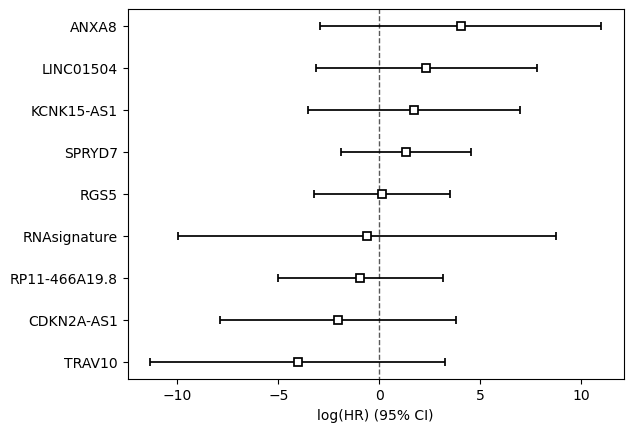

In [8]:

# Plot the results
cph.plot()

### Genomic Survival Predictors - Key Observations:

**Concerning Pattern: All genes have extremely wide confidence intervals**

**Individual Gene Effects:**
1. **ANXA8** - Most Dramatic but Unreliable:
   - HR = 56.38 (5600% increased death risk!)
   - But 95% CI: 0.053 - 59,422 (insanely wide)
   - p = 0.256 (Not significant)

2. **CDKN2A-AS1 & TRAV10** - Protective but Unreliable:
   - HR = 0.13 and 0.018 (87-98% risk reduction)
   - But CIs span from near-zero to extremely high
   - Not statistically significant

3. **Most Genes Show No Clear Signal:**
   - All p-values > 0.25 (far from significant)
   - Confidence intervals all include HR = 1
   - No reliable individual gene effects

**The "RNAsignature" Composite:**
- HR = 0.54 (46% risk reduction)
- But p = 0.897 (completely non-significant)
- CI: 0.000046 - 6,261 (uselessly wide)

**Critical Problem:**
- **Massive overfitting** - too many genes for the sample size
- **Extreme multicollinearity** between genes
- **Unstable estimates** - tiny changes in data cause huge coefficient swings

The individual gene analysis looks statistically unreliable due to overfitting. 

While some genes show dramatic hazard ratios (ANXA8: HR=56, TRAV10: HR=0.02), the enormous confidence intervals indicate these estimates are unstable and should not be trusted. 

The data suggests genomic signals exist but..... may require either regularization methods for stable estimation.